# Libraries and data importing

Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Importing data

In [4]:
activities = pd.read_parquet('../data-raw/activities.parquet')
activities

,contributor,category,repository,activity,date
0,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:19+00:00
1,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:23+00:00
2,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:26+00:00
3,analysis-bot,bot,facebook/react-native,Commenting pull request,2022-11-25 09:55:27+00:00
4,neos-bot,bot,neos/neos-ui-compiled,Pushing commits,2022-11-25 09:55:47+00:00
...,...,...,...,...,...
1015418,798388,human,879434,Reviewing code,2023-04-15 16:06:15+00:00
1015419,798388,human,879434,Reviewing code,2023-04-15 16:07:26+00:00
1015420,784775,human,643744,Creating branch,2023-04-15 16:07:33+00:00
1015421,784775,human,888378,Opening pull request,2023-04-15 16:08:07+00:00


Calculating the date 3 months ago from the last date in the data and filters the dataframe to include only the rows with dates greater than or equal to the date 3 months ago

In [29]:
thresholded_activities = (
    activities[activities['date'] >= activities['date'].max() - pd.DateOffset(months=3)]
    .groupby(['category', 'contributor'])
    .tail(300)
    .reset_index(drop=True)
)
thresholded_activities

,contributor,category,repository,activity,date
0,AmplabJenkins,bot,apache/spark,Commenting pull request,2023-01-15 16:15:53+00:00
1,stickler-ci[bot],bot,Humml87/dolibarr,Pushing commits,2023-01-15 17:31:52+00:00
2,apollo-cla,bot,apollographql/apollo-rs,Commenting pull request,2023-01-15 17:42:50+00:00
3,dune-community-bot,bot,dune-mirrors/dune-fem,Creating branch,2023-01-15 18:00:14+00:00
4,AmplabJenkins,bot,apache/spark,Commenting pull request,2023-01-15 18:20:48+00:00
...,...,...,...,...,...
140748,798388,human,879434,Reviewing code,2023-04-15 16:06:15+00:00
140749,798388,human,879434,Reviewing code,2023-04-15 16:07:26+00:00
140750,784775,human,643744,Creating branch,2023-04-15 16:07:33+00:00
140751,784775,human,888378,Opening pull request,2023-04-15 16:08:07+00:00


In [31]:
time_difference = thresholded_activities.groupby(['contributor', 'category'])['date'].diff().dt.total_seconds()
result_df = thresholded_activities[['contributor', 'category', 'time_difference']]


In [120]:
data = (
    thresholded_activities
    .assign(
        time_difference=(
            thresholded_activities
            .groupby(['contributor', 'category'])['date']
            .diff()
            .dt.total_seconds()
            .dropna()
        )
    )
    .dropna()
    [['category', 'date', 'contributor', 'time_difference']]
)
data['time_difference'] = data['time_difference'].astype('int')

data.head(40)

,category,date,contributor,time_difference
4,bot,2023-01-15 18:20:48+00:00,AmplabJenkins,7495
5,bot,2023-01-15 18:20:51+00:00,AmplabJenkins,3
8,bot,2023-01-15 19:07:28+00:00,pr-benchmarks[bot],9
10,bot,2023-01-15 19:09:58+00:00,poggit-bot,1
12,bot,2023-01-15 20:00:12+00:00,dune-community-bot,7198
13,bot,2023-01-15 20:00:13+00:00,dune-community-bot,1
16,bot,2023-01-15 20:11:02+00:00,pralor-bot,1
17,bot,2023-01-15 20:11:03+00:00,pralor-bot,1
18,bot,2023-01-15 20:11:04+00:00,pralor-bot,1
19,bot,2023-01-15 20:11:05+00:00,pralor-bot,1


# Testing

In [156]:
import seaborn as sns

In [163]:
df = data[data['contributor'] == 'gatsbybot']

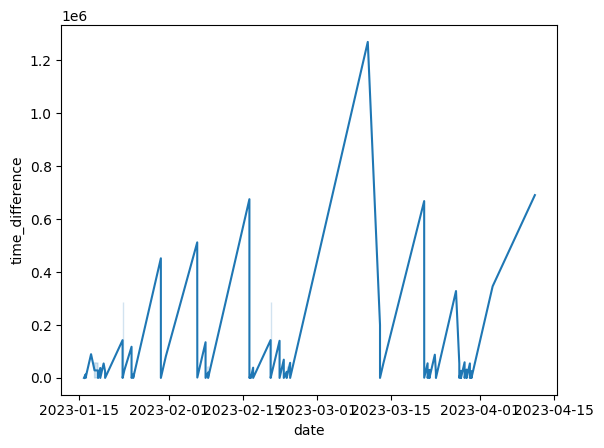

In [164]:

# plot the data using seaborn
sns.lineplot(x='date', y='time_difference', data=df)

# display the plot
plt.show()

In [152]:
# Set the 'date' column as the index
df = df.set_index('date').rename_axis(None)
df['time_difference'].value_counts()

time_difference
1         34
0         19
2         18
3          3
6          2
          ..
5          1
285763     1
5994       1
26174      1
690416     1
Name: count, Length: 63, dtype: int64

In [149]:
frequency = '1H'  # Change this to your desired frequency (e.g., '1H' for hourly)
df_resampled = df.resample(frequency).interpolate()

# Reset the index to make 'date' a regular column again
df_resampled.reset_index(inplace=True)
df_resampled

ValueError: cannot reindex on an axis with duplicate labels

In [143]:
# Interpolate the data to create equally spaced observations
df_interpolated = df.interpolate(method='linear')

/var/folders/x_/_4_hxhrn64sgbhxvknd014l80000gn/T/ipykernel_39115/4099826823.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df.interpolate(method='linear')


In [144]:
df_interpolated

,category,contributor,time_difference
2023-01-16 00:09:09+00:00,bot,gatsbybot,0
2023-01-16 07:25:23+00:00,bot,gatsbybot,26174
2023-01-16 07:25:23+00:00,bot,gatsbybot,0
2023-01-16 07:25:24+00:00,bot,gatsbybot,1
2023-01-16 07:25:25+00:00,bot,gatsbybot,1
...,...,...,...
2023-03-30 07:20:11+00:00,bot,gatsbybot,1
2023-03-30 07:20:13+00:00,bot,gatsbybot,2
2023-03-30 07:20:14+00:00,bot,gatsbybot,1
2023-04-03 07:24:06+00:00,bot,gatsbybot,345832


In [ ]:
# Apply the ARIMA time series forecasting method to predict future data
model = ARIMA(df_interpolated['time_difference'], order=(1, 1, 1))
model_fit = model.fit()
future_data = model_fit.forecast(steps=10)